In [1]:
import os
from os.path import join
from glob import glob
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
import folium.plugins as plugins
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

In [2]:
ais_dir = join(os.path.expanduser("~"), 'data', 'AIS')
data_dir = join(ais_dir, 'Syria')

In [15]:
# df = pd.read_csv(join(ais_dir, 'daily_port_export_sector_weight_value.csv'))
df = pd.read_csv(join(ais_dir, 'daily_port_import_sector_weight_value.csv'))

In [16]:
df = df.loc[df.GID_0=="SYR"].copy()

In [17]:
df['date-entry'] = pd.to_datetime(df['date-entry'])

In [18]:
df['ym'] = df['date-entry'].dt.strftime('%Y-%m')

In [19]:
df = df.loc[df['date-entry']>'2018-12-31'].copy()

In [20]:
sectors = pd.read_excel(join(ais_dir, 'sector_conversion.xlsx'))
industries = pd.read_excel(join(ais_dir, 'sector_description.xlsx'), 'EORA')

In [21]:
sectors.head(2)

WOIT_sector  Industries
0            1           1
1            2           1

In [22]:
industries.head(2)

Industries  Description
0           1  Agriculture
1           2      Fishing

In [23]:
df = df.merge(sectors, on='WOIT_sector')

In [24]:
df = df.merge(industries, on='Industries')

In [25]:
df.head(2)

date-entry      port-name country  WOIT_sector  Import_sector  \
0 2019-01-06  Al Ladhiqiyah   Syria            1     546.403485   
1 2019-01-07  Al Ladhiqiyah   Syria            1     743.406168   

   value_ton_import   Import_value  Import_value_million GID_0       ym  \
0        499.041154  272677.825733              0.272678   SYR  2019-01   
1        499.041154  370990.271672              0.370990   SYR  2019-01   

   Industries  Description  
0           1  Agriculture  
1           1  Agriculture

In [26]:
dfm_imp = df.groupby(['ym','Industries']).agg({
    'country':'first',
    'port-name':'first',
    'Description':'first',
    'Import_sector':'sum',
    'value_ton_import':'sum',
    'Import_value':'sum',
    'Import_value_million':'sum'
})

In [14]:
dfm_exp = df.groupby(['ym','Industries']).agg({
    'country':'first',
    'port-name':'first',
    'Description':'first',
    'Export_sector':'sum',
    'value_ton_export':'sum',
    'Export_value':'sum',
    'Export_value_million':'sum'
})

In [27]:
dfm_exp.reset_index(inplace=True)
dfm_imp.reset_index(inplace=True)
# dfm.reset_index(inplace=True)

In [28]:
dfm = dfm_imp.merge(dfm_exp, on=['ym','Industries','country','port-name','Description'])

In [29]:
dfm.head(2)

ym  Industries country      port-name  Description  Import_sector  \
0  2019-01           1   Syria  Al Ladhiqiyah  Agriculture    1490.096302   
1  2019-01           2   Syria  Al Ladhiqiyah      Fishing       9.807004   

   value_ton_import   Import_value  Import_value_million  Export_sector  \
0       3486.830410  741742.149715              0.741742     521.094504   
1       4623.162713   11334.843468              0.011335      16.268392   

   value_ton_export   Export_value  Export_value_million  
0       3484.602662  614972.655553              0.614973  
1        843.859566   13728.238066              0.013728

In [34]:
# dfm.to_csv(join(ais_dir, "paper_trade_values_daily.csv"))

In [30]:
df_agg = dfm[['ym', 'port-name', 'Import_sector', 'Import_value_million', 'Export_sector', 'Export_value_million']]
# df_agg = dfm[['ym', 'port-name', 'Export_sector', 'Export_value_million']]

In [31]:
df_agg.to_csv(join(ais_dir, "paper_trade_values_ym.csv"))

In [28]:
df_agg = df_agg.groupby(['ym', 'port-name']).sum()

In [29]:
df_agg.reset_index(inplace=True)

In [53]:
# df_agg.set_index('date-entry', inplace=True)
# df_agg.index = df_agg.index.strftime('%m-%d')
# df_agg.reset_index(inplace=True)

In [54]:
# x_dates = df_agg['date-entry'].dt.strftime('%Y-%m-%d').sort_values().unique()
x_dates = df_agg['ym'].unique()

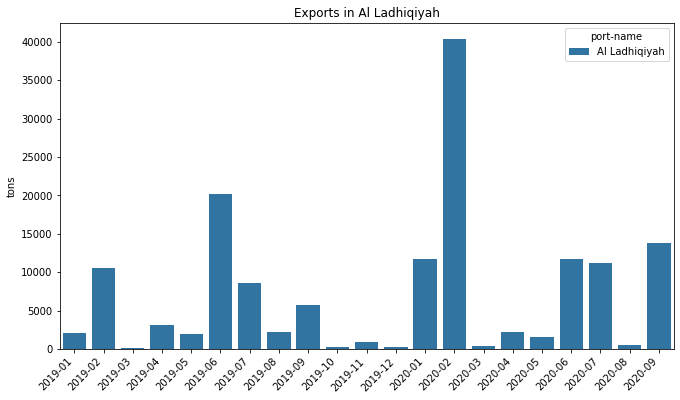

In [55]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.barplot(data=df_agg, x="ym", y='Export_sector', hue='port-name') # hue="polygon_name", palette="tab10"
ax.set(xlabel="", ylabel="tons", title="Exports in Al Ladhiqiyah")
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
plt.show()

In [59]:
df_agg[['ym','Import_sector','Export_sector']]

ym  Import_sector  Export_sector
0   2019-01   10252.467190    2078.347219
1   2019-02   21552.831445   10531.199636
2   2019-03   40068.502797      99.536773
3   2019-04   92870.800027    3133.678289
4   2019-05   84045.322427    2020.237526
5   2019-06   61722.554470   20171.920608
6   2019-07  132905.384189    8629.128093
7   2019-08  127013.598795    2219.734645
8   2019-09   81125.580826    5753.666780
9   2019-10   60233.734180     298.937433
10  2019-11   58269.035673     954.272547
11  2019-12   56825.654440     277.829929
12  2020-01   49534.107862   11744.626867
13  2020-02   30987.458793   40406.547571
14  2020-03  106768.805854     363.708894
15  2020-04  115969.893248    2261.661102
16  2020-05   91177.687034    1613.100129
17  2020-06   90153.705399   11788.226101
18  2020-07  139634.886460   11274.510989
19  2020-08   63784.615695     531.019517
20  2020-09  121556.700939   13765.507983

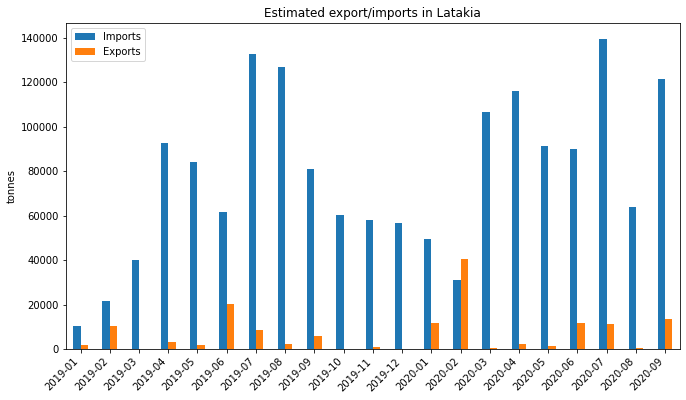

In [57]:
fig, ax = plt.subplots(figsize=(11, 6))
df_agg[['ym','Import_sector','Export_sector']].set_index('ym').plot(ax = ax, kind='bar', stacked=False)
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel="", ylabel="tonnes", title="Estimated export/imports in Latakia")
plt.legend(title='', labels=['Imports', 'Exports']) #loc='upper right', labels=['Raw Data', 'Interpolated']

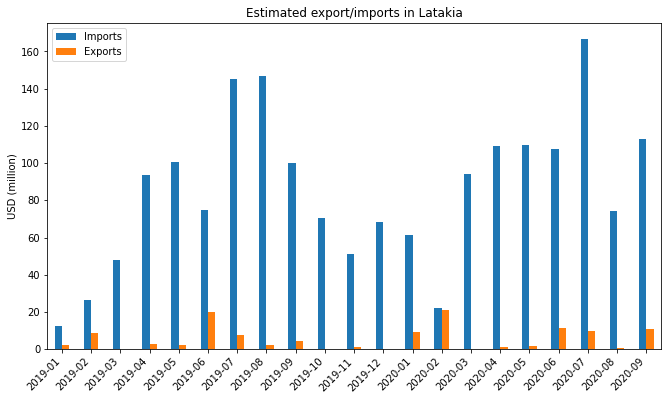

In [58]:
fig, ax = plt.subplots(figsize=(11, 6))
df_agg[['ym','Import_value_million','Export_value_million']].set_index('ym').plot(ax = ax, kind='bar', stacked=False)
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel="", ylabel="USD (million)", title="Estimated export/imports in Latakia")
plt.legend(title='', labels=['Imports', 'Exports']) #loc='upper right', labels=['Raw Data', 'Interpolated']

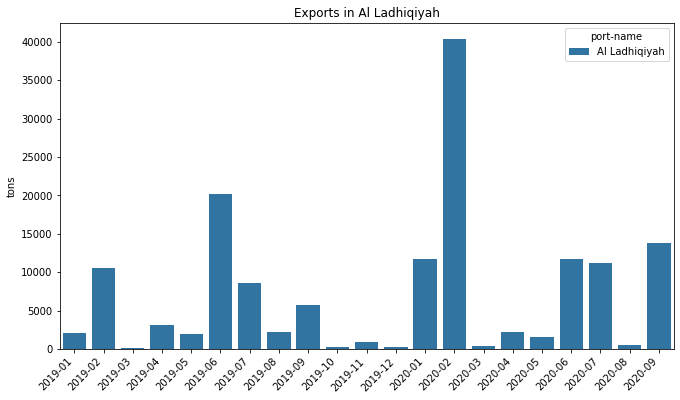

In [46]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.barplot(data=df_agg, x="ym", y='Export_sector', hue='port-name') # hue="polygon_name", palette="tab10"
ax.set(xlabel="", ylabel="tons", title="Exports in Al Ladhiqiyah")
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
plt.show()

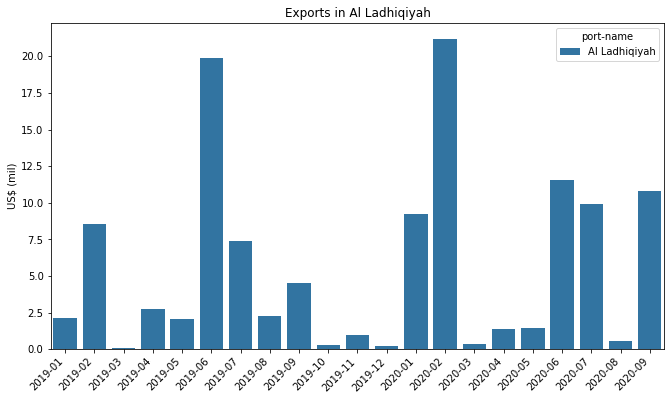

In [49]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.barplot(data=df_agg, x="ym", y='Export_value_million', hue='port-name') # hue="polygon_name", palette="tab10"
ax.set(xlabel="", ylabel="US$ (mil)", title="Exports in Al Ladhiqiyah")
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
plt.show()

In [26]:
# fig, ax = plt.subplots(figsize=(11, 6))
# ax = sns.barplot(data=df_agg, x="date-entry", y='Export_sector', hue='port-name') # hue="polygon_name", palette="tab10"
# ax.set(xlabel="", ylabel="", title="Exports")
# # plt.legend(title='') #loc='upper right', labels=['Raw Data', 'Interpolated']
# ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
# plt.show()
# plt.savefig("../docs/images/Output_Mining_Gas.png", facecolor='white', dpi=300)

In [61]:
df2 = dfm[['ym', 'Description', 'Export_value_million']].copy().set_index('ym')

In [62]:
df2 = df2.pivot(columns='Description', values='Export_value_million').fillna(0)

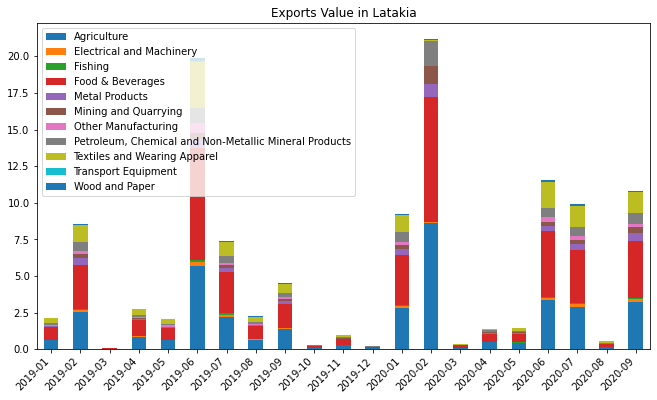

In [63]:
fig, ax = plt.subplots(figsize=(11, 6))
df2.plot(ax = ax, kind='bar', stacked=True)
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel="", ylabel="", title="Exports Value in Latakia")
plt.legend(title='') #loc='upper right', labels=['Raw Data', 'Interpolated']

In [53]:
df2 = dfm[['ym', 'Description', 'Export_sector']].copy().set_index('ym')

In [54]:
df2 = df2.pivot(columns='Description', values='Export_sector').fillna(0)

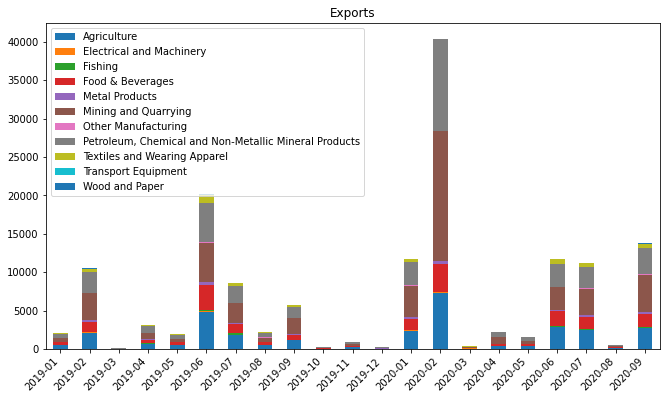

In [55]:
fig, ax = plt.subplots(figsize=(11, 6))
df2.plot(ax = ax, kind='bar', stacked=True)
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel="", ylabel="", title="Exports")
plt.legend(title='') #loc='upper right', labels=['Raw Data', 'Interpolated']